In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from tqdm.notebook import tqdm

from statsmodels.stats.proportion import proportions_ztest

from statsmodels.stats.power import NormalIndPower
import statsmodels.api as sm

# Исходные данные

Этот набор данных включает результаты A/B-тестирования мобильной игры Cookie Cats, исследующего влияние перемещения начальных ворот в игре с уровня 30 на уровень 40. После установки игры игрокам были случайным образом назначены ворота либо на 30 уровне, либо на 40.

In [2]:
df = pd.read_csv('cookie_cats.txt')

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
df['userid'].nunique() #дубликатов userid нет, число соответствует количеству строк

90189

У нас есть данные о 90 189 игроках, которые установили игру во время проведения AB-теста. Переменные:
- userid: уникальный номер, идентифицирующий каждого игрока.
- version: попал ли игрок в контрольную группу (gate_30 - ворота 30 уровня) или группу с перенесенными воротами (gate_40 - ворота 40 уровня).
- sum_gamerounds: количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки.
- retention_1: вернулся ли игрок через 1 день после установки?
- retention_7: вернулся ли игрок через 1 день после установки?

In [6]:
df_control = df.query('version == "gate_30"')
df_test = df.query('version == "gate_40"')

In [7]:
df_control.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
13,2179,gate_30,39,True,False


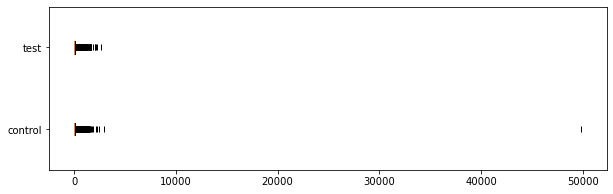

In [8]:
plt.figure(figsize=(10,3))
plt.boxplot([df_control['sum_gamerounds'], df_test['sum_gamerounds']], vert=False, labels = ['control', 'test'], sym='|')
plt.show() #имеем выброс в контрольной группе

In [9]:
df.sort_values('sum_gamerounds', ascending=False).head()

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True


In [10]:
df = df.query('userid != 6390605')
df_control = df_control.query('userid != 6390605') #исключение выброса

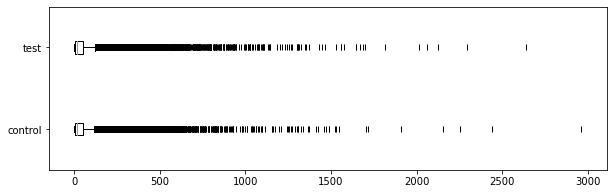

In [11]:
plt.figure(figsize=(10,3))
plt.boxplot([df_control['sum_gamerounds'], df_test['sum_gamerounds']], vert=False, labels = ['control', 'test'], sym='|')
plt.show() #выборки с исключенным выбросом

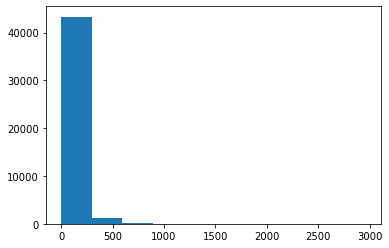

In [12]:
plt.hist(df_control['sum_gamerounds'])
plt.show()

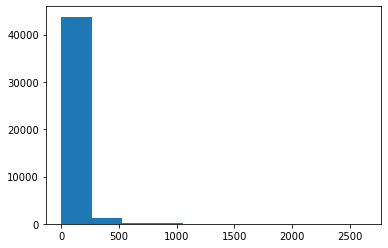

In [13]:
plt.hist(df_test['sum_gamerounds'])
plt.show()

In [14]:
df.groupby('version', as_index=False).agg({'userid': 'count',
                                           'sum_gamerounds': ['mean', 'median'],
                                           'retention_1': 'mean',
                                           'retention_7': 'mean'})

version userid sum_gamerounds        retention_1 retention_7
            count           mean median        mean        mean
0  gate_30  44699      51.342111   17.0    0.448198    0.190183
1  gate_40  45489      51.298776   16.0    0.442283    0.182000

### Трансформация распределения

Применим логарифмическое преобразование к распределению пройденных уровней

In [15]:
df_transformed_log = np.log(df_control.query('sum_gamerounds > 0')['sum_gamerounds'])

In [16]:
df_transformed_log_test = np.log(df_test.query('sum_gamerounds > 0')['sum_gamerounds'])

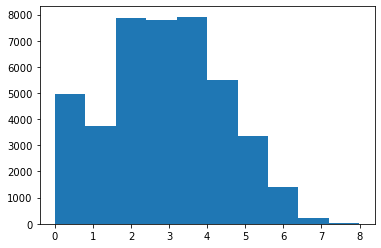

In [17]:
plt.hist(df_transformed_log)
plt.show()

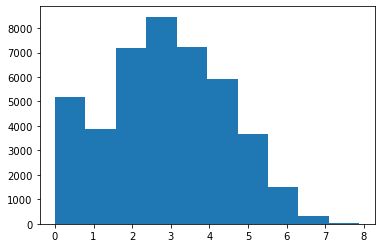

In [18]:
plt.hist(df_transformed_log_test)
plt.show()

In [19]:
df_transformed_log.mean()

2.8895630046553813

In [20]:
df_transformed_log_test.mean()

2.87454313039857

Логарифмическое преобразование решает проблему выбросов, но:
- усложняет интерпретацию результатов
- полученные данные имеют несеметричный вид, распределение выглядит как обрезанное на нуле нормальное
- как будет показано позже, для получения мощности a/b-теста потребуется выборка в 10 раз превышающая текущую. Это всё равно меньше, чем без преобразования, но тем не менее очень много

# A/B-тестирование

Имеем данные о трёх переменных для контрольной и тестовой групп. Проверим значимость различий распределения для среднего числа раундов, проведённых в игре, а также retention на 1 день и на 7 день после установки.

Проверяем одновременно три гипотезы, используем поправку Бонферрони для уровня значимости.

In [21]:
alpha = 0.05 / 3
alpha

0.016666666666666666

## 1. Число проведённых раундов

Какой метод расчета p-value использовать? Имеем дело со скошенным распределением с очень утолщенным хвостом. T-test может давать некорректные результаты. Тогда сравниваем распределения, используем U-критерий Манна — Уитни.

H0: распределения количества сыгранных раундов в группе A и группе B совпадают

H1: распределения количества сыгранных раундов в группе A и группе B различаются

Проверим как будет вести себя p-value на выборках где не должно получаться статистических различий. Будем генерировать по две подвыборки из контрольной группы. Так как мы знаем, что эти подвыборки принадлежат одной выборке, то ожидаем, что FPR соответствует значению статистической значимости. Иными словами pvalue распределено равномерно.

In [22]:
n = 1000
result = []
for i in tqdm(range(n)):
    a = df_control['sum_gamerounds'].sample(frac=1/2,replace=True,random_state=i)
    b = df_control['sum_gamerounds'].sample(frac=1/2,replace=True,random_state=n-i)
    pvalue = stats.mannwhitneyu(a,b,use_continuity=False,alternative='two-sided')[1]
    result.append(pvalue)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
result = pd.Series(result)

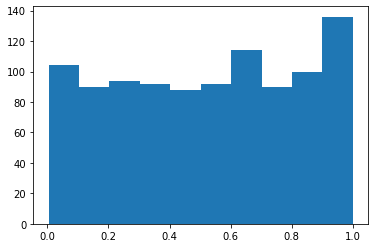

In [24]:
plt.hist(result)
plt.show()

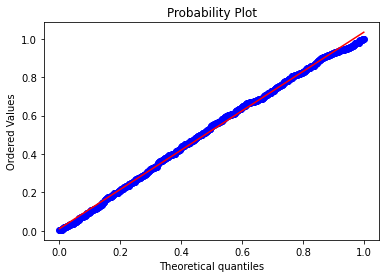

In [25]:
stats.probplot(result, dist='uniform', plot=plt)
plt.show()

In [26]:
(result < alpha).mean(), alpha #FPR и alpha

(0.016, 0.016666666666666666)

P-value распределено равномерно, FPR соответствует установленному alpha.
Можем использовать критерий Манна-Уитни

### 1.2. Проверка гипотез

In [27]:
a = df_control['sum_gamerounds']
b = df_test['sum_gamerounds']

stats.mannwhitneyu(a,b,use_continuity=False,alternative='two-sided')

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089153761189497)

pvalue > alpha

Мы не можем отвергнуть нулевую гипотезу, а значит и не можем говорить о статистической значимости в различиях полученных средних.

## 2. Retention на первый день

H0: retention на первый день в группе A и группе B равны

H1: retention на первый день в группе A и группе B различны

In [28]:
group_size_1 = np.array([df_control['userid'].count(),
                       df_test['userid'].count()])
retention_1 = np.array([df_control.query('retention_1')['userid'].count(),
                      df_test.query('retention_1')['userid'].count()])

In [29]:
list(group_size_1)

[44699, 45489]

In [30]:
list(retention_1)

[20034, 20119]

In [31]:
pvalue = proportions_ztest(retention_1, group_size_1)[1]
pvalue, alpha

(0.0739207603418346, 0.016666666666666666)

In [32]:
pvalue < alpha

False

## 2. Retention на седьмой день

H0: retention на седьмой день в группе A и группе B равны

H1: retention на седьмой день в группе A и группе B различны

In [33]:
group_size_7 = np.array([df_control['userid'].count(),
                       df_test['userid'].count()])
retention_7 = np.array([df_control.query('retention_7')['userid'].count(),
                      df_test.query('retention_7')['userid'].count()])

In [34]:
list(group_size_7)

[44699, 45489]

In [35]:
list(retention_7)

[8501, 8279]

In [36]:
pvalue = proportions_ztest(retention_7, group_size_7)[1]
pvalue, alpha

(0.0015917731773993442, 0.016666666666666666)

In [37]:
pvalue < alpha

True

# Оценка мощности

Данный датасет и описание к нему не содержат допустимых уровней ошибок первого и второго рода, размер эффекта. Попробуем оценить достигаемую мощность. Параметры подбираются таким образом, чтобы рассчитаные размеры выборок соответствовали имеющимся.

In [38]:
def get_sample_size(mde, alpha=0.05, power=0.8, ratio=1, discrete=True, std=None, baseline=None):
    if discrete:
        effect_size = sm.stats.proportion_effectsize(baseline, baseline + mde)
    else:
        effect_size = mde / std
    
    analysis = NormalIndPower()
    result = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=ratio, alternative='two-sided')
    sample_size = int(np.ceil(result))
    
    return sample_size, sample_size*ratio

### Число сыгранных раундов

In [39]:
get_sample_size(mde=2, alpha=alpha, power=0.7, ratio=1, discrete=False, std=df_control['sum_gamerounds'].std())

(44356, 44356)

Имеем мощность 70% c MDE = 2 раунда. MDE гораздо больше полученных различий

In [40]:
get_sample_size(mde=0.01, alpha=alpha, power=0.8, ratio=1, discrete=False, std=df_transformed_log.std())

(497450, 497450)

### Retention через 1 день

In [41]:
get_sample_size(mde=0.005, alpha=alpha, power=0.2, ratio=1, baseline = df_control['retention_1'].mean())

(47719, 47719)

Имеем мощность 20% c MDE = 0.05%. MDE выбран таким образом, чтобы быть слегка меньше полученных в результате эксперимента различий

### Retention через 7 дней

In [42]:
get_sample_size(mde=0.005, alpha=alpha, power=0.3, ratio=1, baseline = df_control['retention_7'].mean())

(43495, 43495)

Имеем мощность 30% c MDE = 0.05%.

## Эксперименты с размером выброки, мощностью и альфой

## 1. Число раундов

In [43]:
get_sample_size(mde=0.5, alpha=0.5, power=0.8, ratio=1, discrete=False, std=df_control['sum_gamerounds'].std())

(177306, 177306)

In [44]:
get_sample_size(mde=0.05, alpha=0.5, power=0.6, ratio=1, discrete=False, std=df_control['sum_gamerounds'].std())

(4332486, 4332486)

In [45]:
get_sample_size(mde=0.01, alpha=0.5, power=0.8, ratio=1, discrete=False, std=df_transformed_log.std())

(101107, 101107)

## 2. Retention через 1 день

In [46]:
get_sample_size(mde=0.005, alpha=alpha, power=0.8, ratio=1, baseline = df_control['retention_1'].mean())

(207345, 207345)

In [47]:
get_sample_size(mde=0.005, alpha=alpha, power=0.8, ratio=1, baseline = df_control['retention_7'].mean())

(130279, 130279)

## 3. Retention через 7 дней

In [48]:
get_sample_size(mde=0.005, alpha=0.05/2, power=0.8, ratio=1, baseline = df_control['retention_1'].mean())

(188251, 188251)

In [49]:
get_sample_size(mde=0.005, alpha=0.05/2, power=0.8, ratio=1, baseline = df_control['retention_7'].mean())

(118282, 118282)

# Вывод

In [50]:
df.groupby('version', as_index=False).agg({'userid': 'count',
                                           'sum_gamerounds': 'mean',
                                           'retention_1': 'mean',
                                           'retention_7': 'mean'})

,version,userid,sum_gamerounds,retention_1,retention_7
0,gate_30,44699,51.342111,0.448198,0.190183
1,gate_40,45489,51.298776,0.442283,0.182000


- Для распределения числа игровых раундов p-value > alpha. Мы не можем отвергнуть нулевую гипотезу, которая утверждает, что распределения не различаются.
- Для retention на первый день также не отвергаем нулевую гипотезу, соответственно различия не являются статистически значимыми.
- Для retention на седьмой день p-value < alpha, признаём различия статистически значимыми. Данная метрика ниже на 0.8% для тестовой группы. 
- Изменения retention меньше процента. Если для retention_1 установить MDE=0.5%, то мощность будет 20% (при данных размерах выборок). Возможно, при "планировании эксперимента" (в кавычках, т.к. эта часть отсутствует в описании к датасету) ожидались более существенные изменения данных метрик, либо тест завершили досрочно. Также велика вероятность, что при проверке гипотез мы совершили ошибку второго рода, т.е. две сравниваемые группы действительно различаются, но тест не обладает должной чувствительностью чтобы признать их статистически значимыми. 
- Если мы хотим провести повторный эксперимент с большей чувствительностью, то потребуется больший сумарный размер двух выборок. Для дополнительного повышения чувствительности можно предложить снизить количество сравниваемых метрик, выбрав наиболее важные/важную или другие, более чувствительные к изменения метрики.
- Для сравнения средних величин sum_gamerounds, можно использовать логарифмическую трансформацию распределения. Она существенно повышает чувствительность теста, но в то же время существенно усложняет интерпретацию результатов.